# Creating a Neural Network Using Mircro Grad

In [93]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [94]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
      
        return out
  
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out
  
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
    
        return out
  
  
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [95]:
from graphviz import Digraph


def trace(root): 
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



In [96]:


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    '''
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    '''
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


    



In [97]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)
print(len(n.parameters()))
n.parameters()

41


[Value(data=-0.06645115884380859),
 Value(data=-0.04615157686608318),
 Value(data=0.8769644249557489),
 Value(data=-0.3050779691734373),
 Value(data=0.5534154146105137),
 Value(data=0.20929171518613754),
 Value(data=0.7894424628123502),
 Value(data=-0.00869902528116584),
 Value(data=-0.8518006010814232),
 Value(data=0.3638448621467134),
 Value(data=-0.3433854957192881),
 Value(data=0.723601698994615),
 Value(data=-0.1475849233796871),
 Value(data=0.6438003047375209),
 Value(data=0.12437641035376323),
 Value(data=0.10279692702619059),
 Value(data=-0.2618748353140441),
 Value(data=0.8749023943269563),
 Value(data=0.7713129502921194),
 Value(data=0.4040728630191788),
 Value(data=-0.16722343190395805),
 Value(data=0.17515893128374516),
 Value(data=0.2766367360777682),
 Value(data=0.10398087808002288),
 Value(data=0.1110573768196752),
 Value(data=-0.9513700760194097),
 Value(data=0.6172714184183163),
 Value(data=0.3041436308327161),
 Value(data=0.1783458695382858),
 Value(data=-0.7530161286

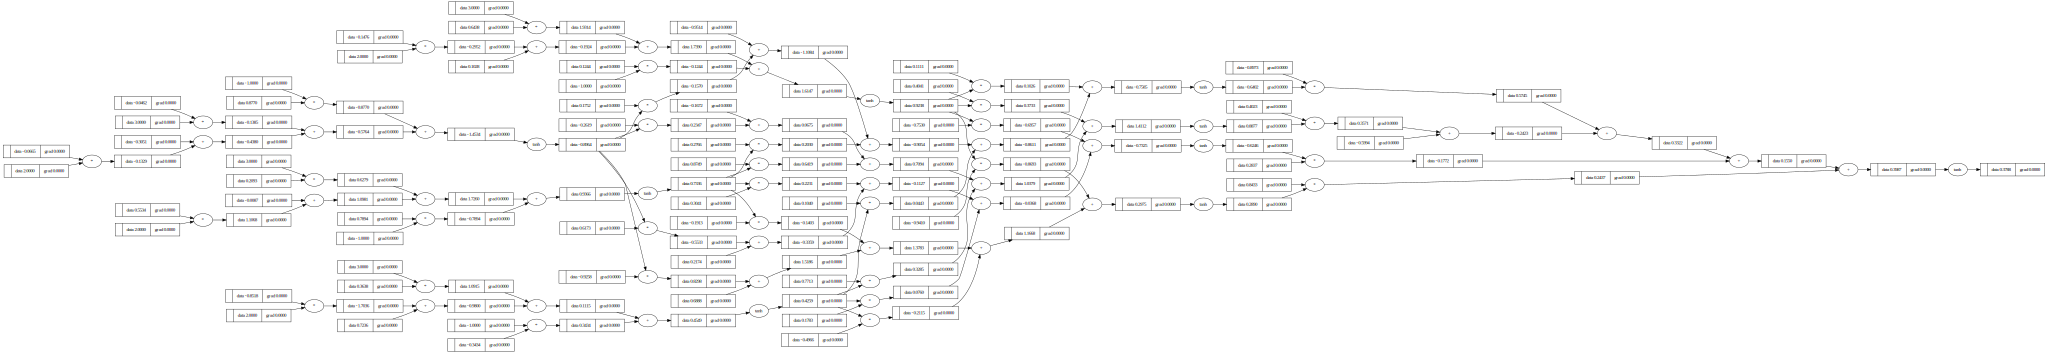

In [98]:
draw_dot(n(x))

In [99]:
# This graph has the following number of arrows:

# From three imputs to the first hidden layer with 4 neurons:
# you are  muliplying each in put by the correspoint weight in each neruon then adding:

(3 + 2) * 4 + (4 + 3)*4 + (4 + 3)



55

In [100]:
# Example data set



xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]


ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.3788334374498657),
 Value(data=0.7026431898178342),
 Value(data=-0.2656912803011005),
 Value(data=0.6221467541456822)]

In [101]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.96682410149188)

In [102]:
loss.backward()

In [1]:
draw_dot(loss)

NameError: name 'draw_dot' is not defined

In [104]:
n.layers[0].neurons[0].w[0]

Value(data=-0.06645115884380859)

In [105]:
n.layers[0].neurons[0].w[0].grad

-0.8530619870247265

In [106]:
n.layers[0].neurons[0].w[0].data

-0.06645115884380859

In [107]:
for p in n.parameters():
    p.data += -0.01 * p.grad
    

In [108]:
n.layers[0].neurons[0].w[0].data           # got a bit greater

-0.05792053897356132

In [109]:
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.735463049120807)

In [116]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0.0
    
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.1 *p.grad
    
    print(k, loss.data)
    

0 0.007469158745040063
1 0.007255694023096098
2 0.0070534546361926635
3 0.006861596461414371
4 0.006679356978953864
5 0.006506045713774885
6 0.006341035983561404
7 0.006183757750034666
8 0.0060336914058692235
9 0.0058903623578968395
10 0.005753336290438811
11 0.0056222150115266024
12 0.005496632800300536
13 0.005376253186674649
14 0.005260766104948786
15 0.005149885371846141
16 0.005043346446792061
17 0.004940904438386256
18 0.0048423323261752105
19 0.004747419371171641


In [117]:
ypred

[Value(data=0.9599246358369635),
 Value(data=-0.9840380188753999),
 Value(data=-0.9589697115404294),
 Value(data=0.9653140497337324)]